In [150]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

In [151]:
# Define columns
timestamp_col = 'Timestamp'
time_col_s = 'Time [s]'
voltage_col = 'Voltage [V]'
current_col = 'Current [A]'
temperature_col = 'Temperature [degC]'
capacity_col = 'Capacity [Ah]'
capacity_cc_col = 'Cumulative_Capacity_Ah'
soc_col = 'SOC [-]'

In [152]:
# Directory paths
raw_data_directory = '../../datasets/Panasonic_dataset/Panasonic_data'
parsed_data_directory = '../../datasets/Panasonic_dataset/Panasonic_parsed'
processed_data_directory = '../../datasets/Panasonic_dataset/Panasonic_processed'

os.makedirs(parsed_data_directory, exist_ok=True)
os.makedirs(processed_data_directory, exist_ok=True)

In [153]:
def parse_raw_data(file_path: str) -> pd.DataFrame:
    with open(file_path) as f:
        lines = f.readlines()

    column_index = lines.index(next(filter(lambda l: 'TimeStamp' in l, lines)))
    
    column_line = lines[column_index].split(',')
    data_lines = [l.split(',') for l in lines[column_index + 2:]]
    
    abs_timestamp_data = []
    for l in data_lines:
        abs_timestamp_data.append(pd.Timestamp(l[column_line.index('TimeStamp')]))

    df = pd.DataFrame({
        timestamp_col: abs_timestamp_data,
        time_col_s: [float(l[column_line.index('Time')]) for l in data_lines],
        voltage_col: [float(l[column_line.index('Voltage')]) for l in data_lines],
        current_col: [float(l[column_line.index('Current')]) for l in data_lines],
        temperature_col: [float(l[column_line.index('Battery_Temp_degC')]) for l in data_lines],
        capacity_col: [float(l[column_line.index('Ah')]) for l in data_lines],
    })

    return df

In [191]:
# def get_pOCV_SOC_interp_fn(df) -> (interp1d, interp1d):
#     # Process discharge data
#     df_discharge = df[df[current_col] < 0].copy()
#     df_discharge[capacity_col] = df_discharge[capacity_col] - df_discharge[capacity_col].iloc[0]
#     df_discharge[soc_col] = 1 - abs(df_discharge[capacity_col] / df_discharge[capacity_col].iloc[-1])
#     max_voltage_discharge = df_discharge[voltage_col].max()
#     df_discharge = df_discharge[df_discharge[voltage_col] <= max_voltage_discharge]
#     discharge_interp = interp1d(df_discharge[voltage_col], df_discharge[soc_col], bounds_error=False, fill_value="extrapolate")

#     # Process charge data
#     df_charge = df[df[current_col] > 0].copy()
#     df_charge[capacity_col] = df_charge[capacity_col] - df_charge[capacity_col].iloc[0]
#     df_charge[soc_col] = abs(df_charge[capacity_col]) / df_charge[capacity_col].iloc[-1]
#     max_voltage_charge = df_charge[voltage_col].max()
#     df_charge = df_charge[df_charge[voltage_col] <= max_voltage_charge]
#     charge_interp = interp1d(df_charge[voltage_col], df_charge[soc_col], bounds_error=False, fill_value="extrapolate")

#     return charge_interp, discharge_interp
def get_pOCV_SOC_interp_fn(df):
    def dummy_soc_fn(voltage):
        return 0.5  # если нет данных — возвращаем нейтральное значение

    # Discharge
    df_discharge = df[df[current_col] < 0].copy()
    if len(df_discharge) >= 2:
        df_discharge[capacity_col] = df_discharge[capacity_col] - df_discharge[capacity_col].iloc[0]
        df_discharge[soc_col] = 1 - abs(df_discharge[capacity_col] / df_discharge[capacity_col].iloc[-1])
        discharge_interp = interp1d(df_discharge[voltage_col], df_discharge[soc_col],
                                    bounds_error=False, fill_value="extrapolate")
    else:
        discharge_interp = dummy_soc_fn

    # Charge
    df_charge = df[df[current_col] > 0].copy()
    if len(df_charge) >= 2:
        df_charge[capacity_col] = df_charge[capacity_col] - df_charge[capacity_col].iloc[0]
        df_charge[soc_col] = abs(df_charge[capacity_col]) / df_charge[capacity_col].iloc[-1]
        charge_interp = interp1d(df_charge[voltage_col], df_charge[soc_col],
                                 bounds_error=False, fill_value="extrapolate")
    else:
        charge_interp = dummy_soc_fn

    return charge_interp, discharge_interp


def get_max_capacities(df):
    # Find the index where the discharge phase ends and the charge phase begins
    charge_start_index = df[df[current_col] > 0].index[0]

    # Split the DataFrame into discharge and charge phases
    df_discharge = df.iloc[:charge_start_index]
    df_charge = df.iloc[charge_start_index:]

    # Calculate max capacities for discharge and charge phases
    max_discharge_capacity = df_discharge[capacity_col].max() - df_discharge[capacity_col].min()
    max_charge_capacity = df_charge[capacity_col].max() - df_charge[capacity_col].min()

    return max_charge_capacity, max_discharge_capacity

def get_initial_soc(df, charge_soc_fn, discharge_soc_fn, current_col, voltage_col):
    initial_voltage = df[voltage_col].iloc[0]

    # Find the index of the first non-zero current
    first_non_zero_index = df[df[current_col] != 0].index[0]
    first_non_zero_current = df[current_col].iloc[first_non_zero_index]

    # Determine SOC based on the sign of the first non-zero current
    if first_non_zero_current < 0:
        return discharge_soc_fn(initial_voltage)
    else:
        return charge_soc_fn(initial_voltage)

In [192]:
def process_file(args):
    csv_file_name, T = args
    parsed_dir = os.path.join(parsed_data_directory, T)
    processed_dir = os.path.join(processed_data_directory, T)
    os.makedirs(parsed_dir, exist_ok=True)
    os.makedirs(processed_dir, exist_ok=True)

    # Parsing raw data
    raw_file_path = os.path.join(raw_data_directory, T, f'{csv_file_name}.csv')
    df = parse_raw_data(raw_file_path)

    # Save parsed data
    parsed_file_path = os.path.join(parsed_dir, f'{csv_file_name}_parsed.csv')
    df.to_csv(parsed_file_path, index=False)

    charge_soc_fn, discharge_soc_fn = get_pOCV_SOC_interp_fn(df)
    
    smoothed_current = df[current_col].rolling(window=100, center=True, min_periods=1).mean()

    df['Time_diff'] = df[time_col_s].diff().fillna(0) / 3600
    df['Cumulative_Capacity_Ah'] = (df[current_col] * df['Time_diff']).cumsum()

    initial_voltage = df[voltage_col].iloc[0]
    first_index = smoothed_current[smoothed_current.abs() > 0.1].first_valid_index()
    if first_index is None:
        first_index = 0
    initial_current = smoothed_current.iloc[first_index]
    initial_voltage = df[voltage_col].iloc[first_index]

    if initial_current < 0:
        initial_soc = float(discharge_soc_fn(initial_voltage))
    else:
        initial_soc = float(charge_soc_fn(initial_voltage))

    # Расчёт полной delta Q
    q_min = df['Cumulative_Capacity_Ah'].min()
    q_max = df['Cumulative_Capacity_Ah'].max()
    total_capacity = q_max - q_min
    if total_capacity <= 0:
        total_capacity = 1  # Чтобы избежать деления на ноль

    # Нормализация SOC
    df[soc_col] = initial_soc + (df['Cumulative_Capacity_Ah'] - df['Cumulative_Capacity_Ah'].iloc[first_index]) / total_capacity
    df[soc_col] = df[soc_col].clip(0, 1)  # Ограничение от 0 до 1


    # Save processed data
    processed_file_path = os.path.join(processed_dir, f'{csv_file_name}_processed.csv')
    df.to_csv(processed_file_path, index=False)

In [193]:
temperatures = [folder for folder in os.listdir(raw_data_directory) if 'degC' in folder]
tasks = []
for T in temperatures:
    raw_data_T_directory = os.path.join(raw_data_directory, T)
    csv_files = [f for f in os.listdir(raw_data_T_directory) if f.endswith('.csv')]
    for csv_file in csv_files:
        csv_file_name = csv_file.split(".csv")[0]
        tasks.append((csv_file_name, T))

total_tasks = len(tasks)

In [199]:
for task in tqdm(tasks):
    process_file(task)

100%|██████████| 51/51 [05:13<00:00,  6.16s/it]


In [69]:
temperatures

['0degC', 'n20degC', '25degC', '10degC', 'n10degC']

In [210]:
df_temp = []
for T in temperatures:
    processed_dir = os.path.join(processed_data_directory, T)
    us06_file_path = next((f for f in os.listdir(processed_dir) if 'UDDS' in f), None)
    df = pd.read_csv(os.path.join(processed_dir, us06_file_path))
    df_temp.append(df)

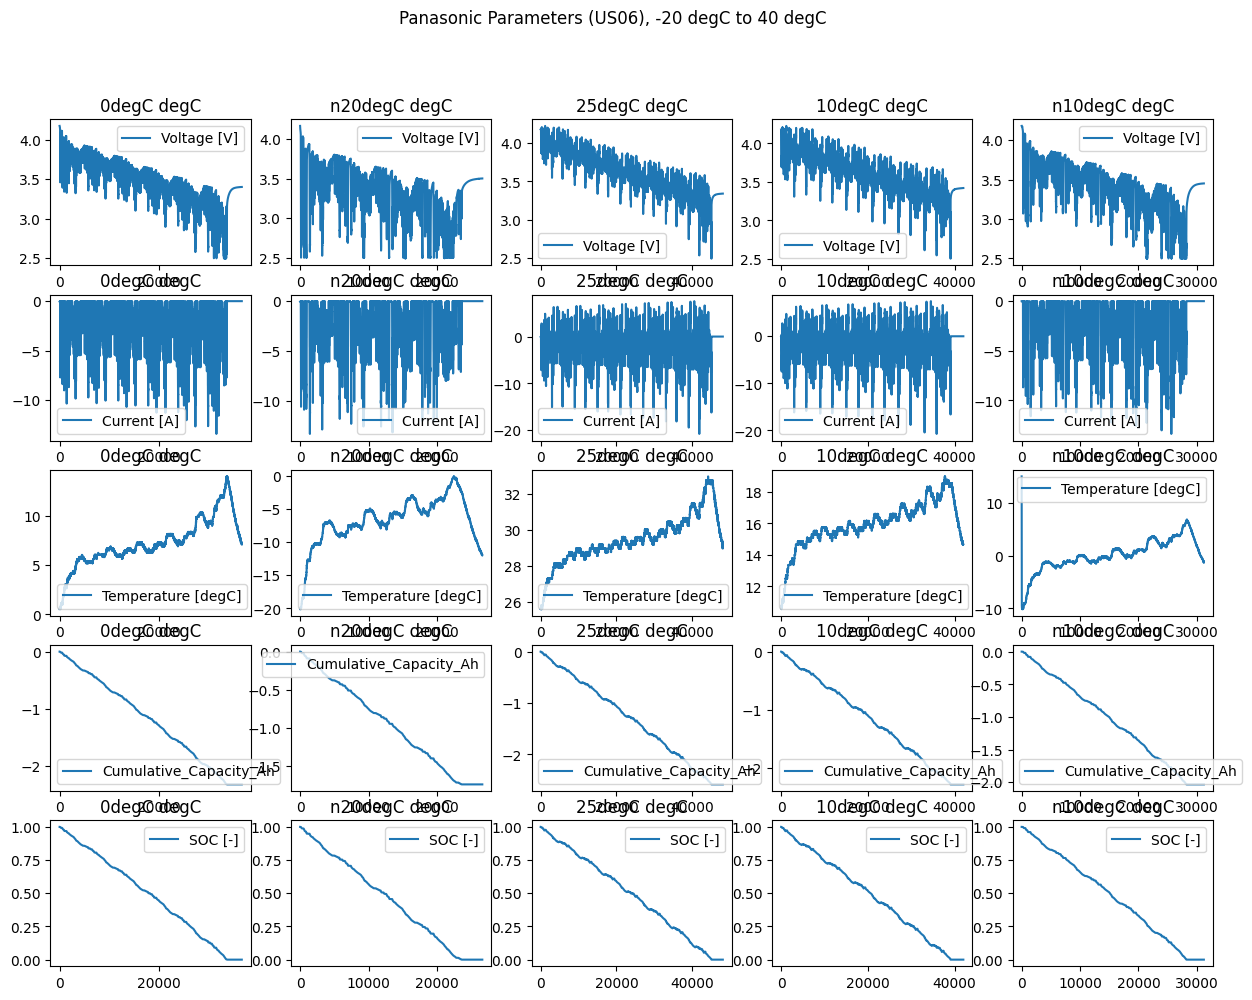

In [209]:
plot_cols = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Cumulative_Capacity_Ah', 'SOC [-]']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=len(temperatures), figsize=(15, 11))
fig.suptitle("Panasonic Parameters (US06), -20 degC to 40 degC")

for i, col in enumerate(plot_cols):
    for j in range(len(df_temp)):
        axs[i, j].plot(df_temp[j][col], label=f'{col}')
        axs[i, j].set_title(f'{temperatures[j]} degC')
        axs[i, j].legend()


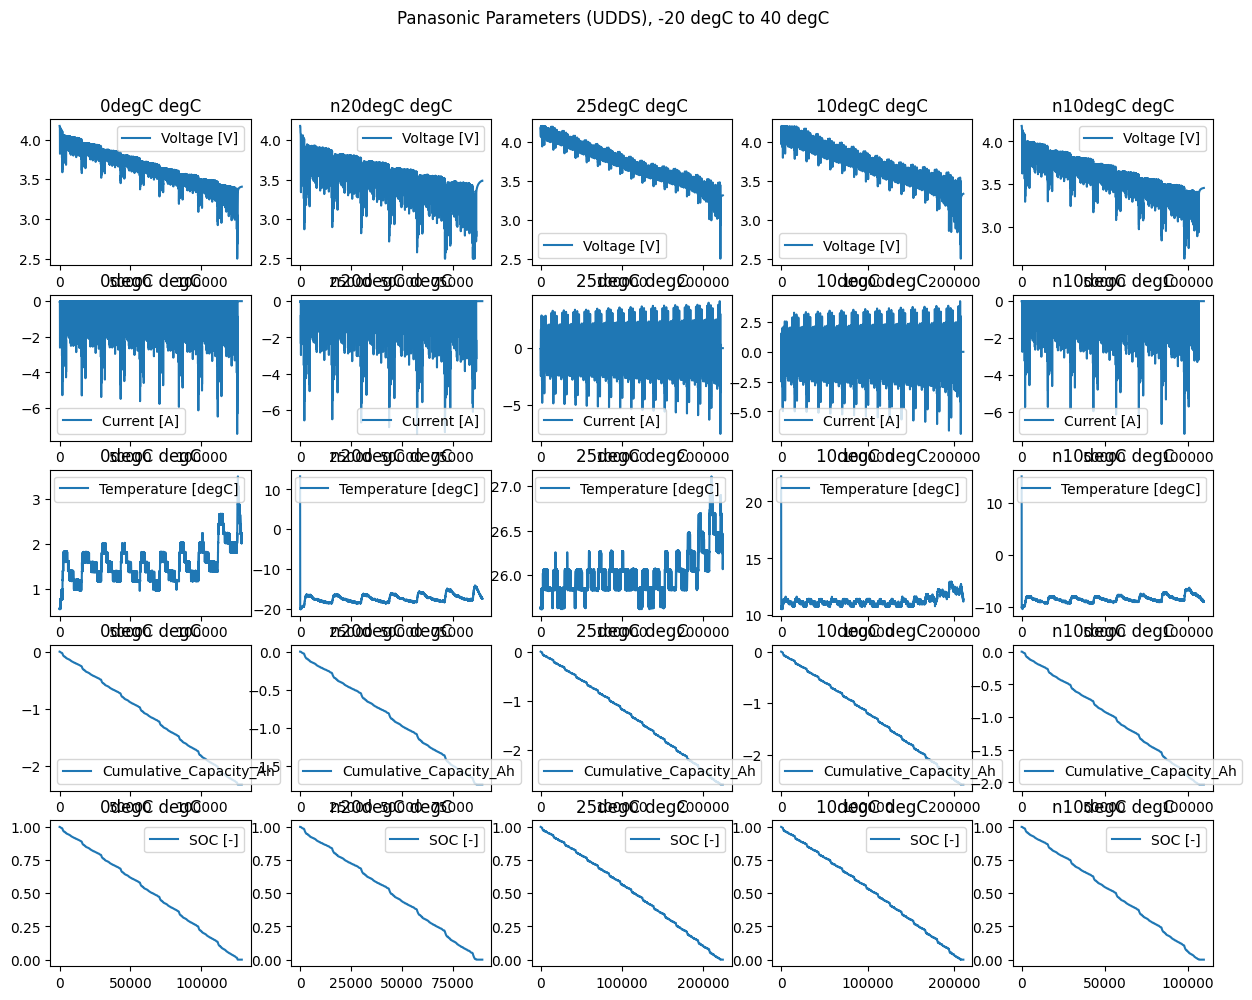

In [211]:
plot_cols = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'Cumulative_Capacity_Ah', 'SOC [-]']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=len(temperatures), figsize=(15, 11))
fig.suptitle("Panasonic Parameters (UDDS), -20 degC to 40 degC")

for i, col in enumerate(plot_cols):
    for j in range(len(df_temp)):
        axs[i, j].plot(df_temp[j][col], label=f'{col}')
        axs[i, j].set_title(f'{temperatures[j]} degC')
        axs[i, j].legend()

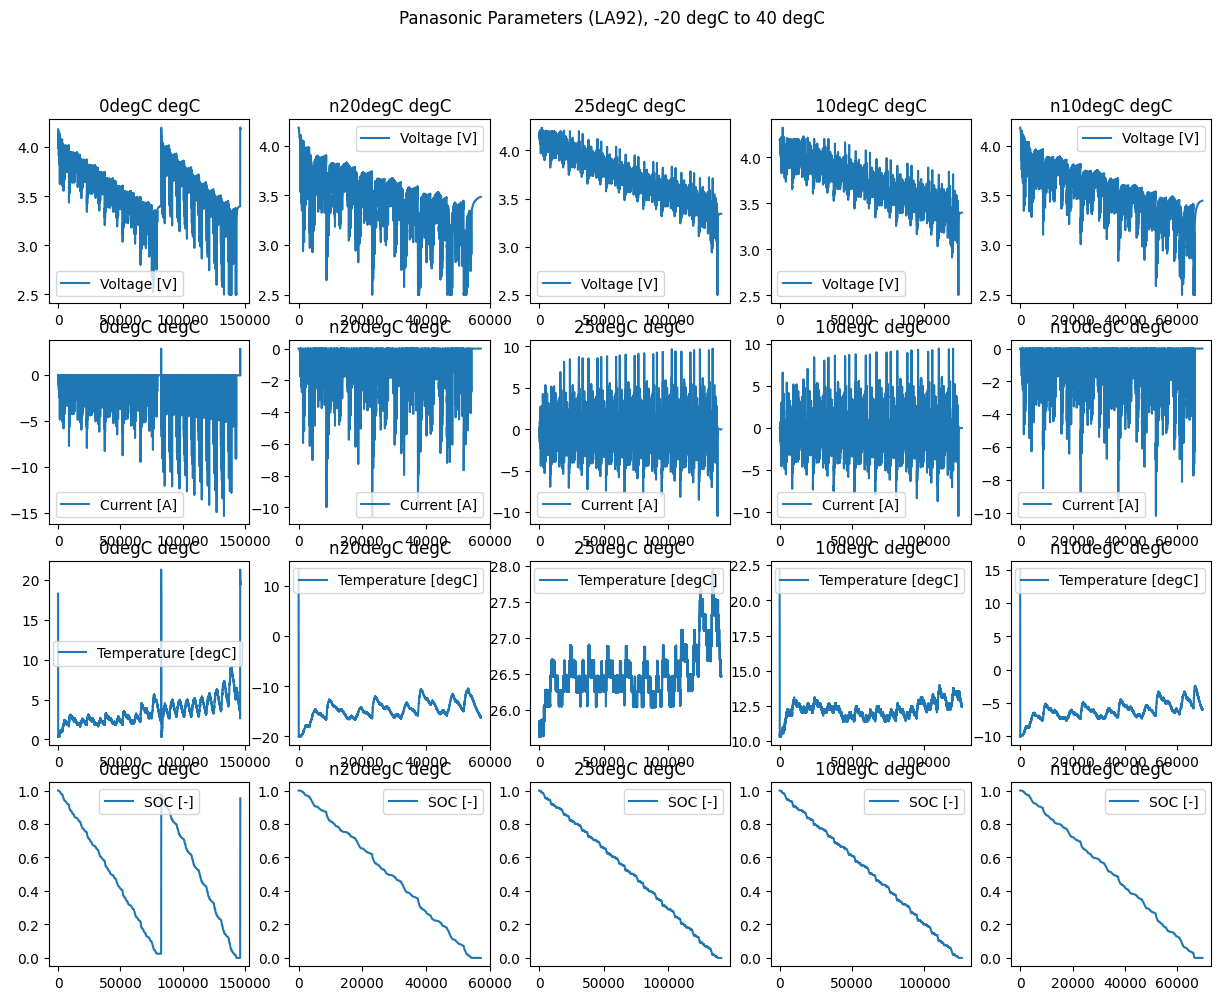

In [205]:
plot_cols = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'SOC [-]']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=len(temperatures), figsize=(15, 11))
fig.suptitle("Panasonic Parameters (LA92), -20 degC to 40 degC")

for i, col in enumerate(plot_cols):
    for j in range(len(df_temp)):
        axs[i, j].plot(df_temp[j][col], label=f'{col}')
        axs[i, j].set_title(f'{temperatures[j]} degC')
        axs[i, j].legend()

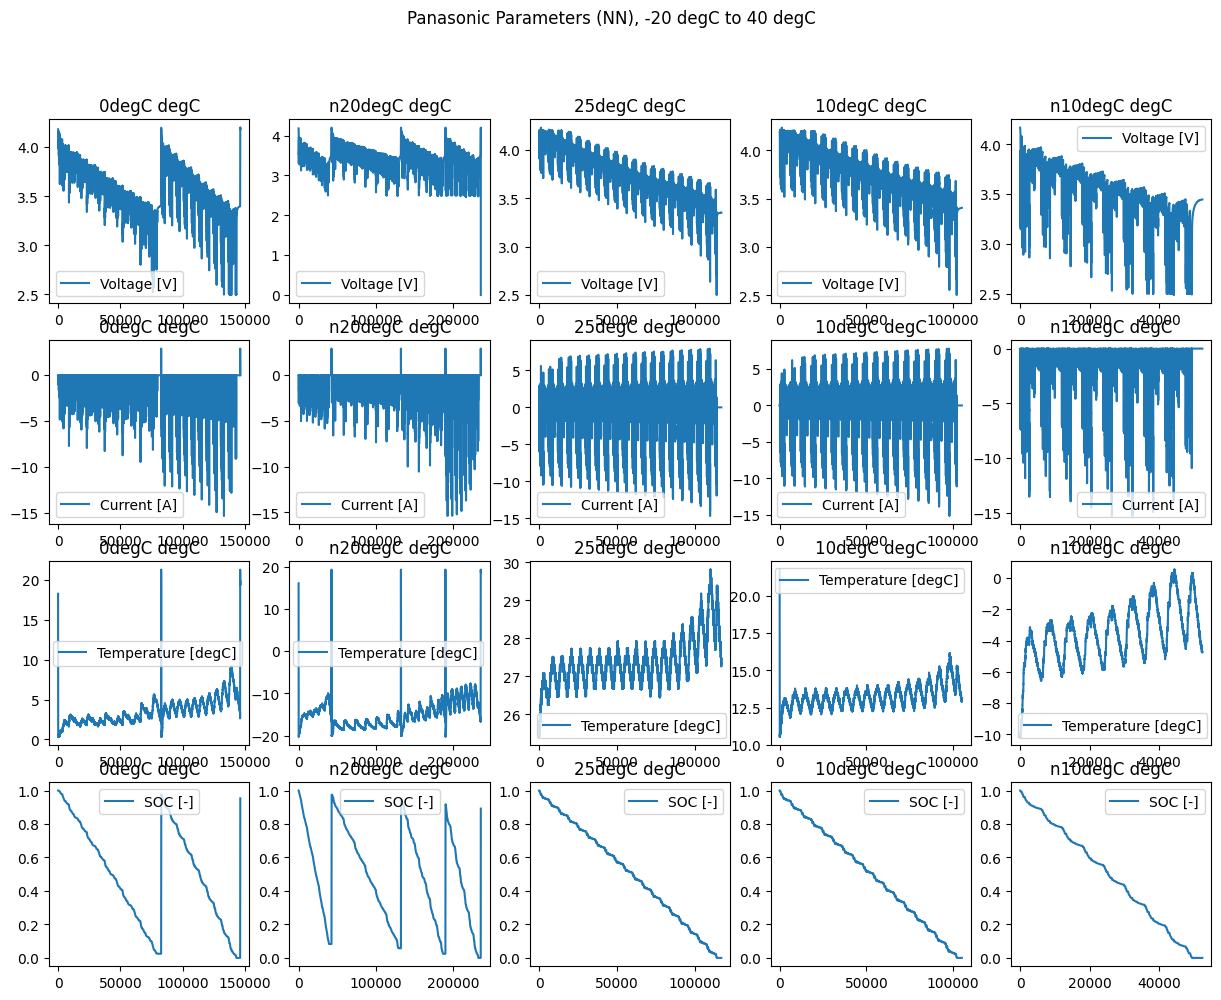

In [207]:
plot_cols = ['Voltage [V]', 'Current [A]', 'Temperature [degC]', 'SOC [-]']

fig, axs = plt.subplots(nrows=len(plot_cols), ncols=len(temperatures), figsize=(15, 11))
fig.suptitle("Panasonic Parameters (NN), -20 degC to 40 degC")

for i, col in enumerate(plot_cols):
    for j in range(len(df_temp)):
        axs[i, j].plot(df_temp[j][col], label=f'{col}')
        axs[i, j].set_title(f'{temperatures[j]} degC')
        axs[i, j].legend()